In [1]:
from common.torch_utils import get_available_device

device = get_available_device()

Platform: Darwin
Release: 21.5.0
MPS available: True
CUDA available: False
Selected device: mps


## Model

from fcos import FCOS
from fcos import build_backbone
from dataset import LabelsCodec

target_resolution = (256, 256)
model = FCOS(
    backbone=build_backbone('resnet50'),
    labels_codec=LabelsCodec(),
    res=target_resolution,
)

## Dataloader

In [7]:
from dataset.loader import build_dataloader

train_dataset = build_dataloader('train', batch_size=4)
img, boxes, labels = next(iter(train_dataloader))
print(img.shape)
print(boxes)
print(labels)

torch.Size([4, 256, 256, 3])
[tensor([[  0.,   0., 256., 256.]]), tensor([[  0.0000,  57.3517, 244.2937, 252.2040],
        [  0.0000,  82.8208,  13.0592, 125.4732],
        [  0.0000,  73.3779,   7.4921, 100.7340],
        [177.4791,  47.6897, 196.9380,  74.1757],
        [198.0295,  50.7517, 218.5867,  73.8777]]), tensor([[ 11.6256,  53.0196, 160.9451, 209.0701]]), tensor([[  0.0000,   0.0000, 256.0000, 253.0948],
        [ 99.2443,   6.5467, 208.3805, 120.3851],
        [156.5887, 105.0511, 256.0000, 256.0000]])]
[tensor([15], dtype=torch.int32), tensor([11,  0,  0,  0,  0], dtype=torch.int32), tensor([15], dtype=torch.int32), tensor([18,  0, 18], dtype=torch.int32)]


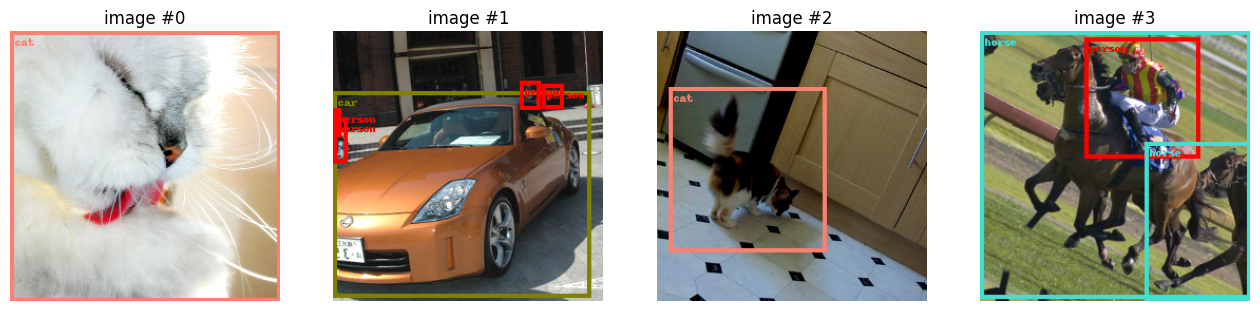

In [8]:
from dataset.visualization import visualize_batch
from dataset.labels_codec import LabelsCodec

visualize_batch(img, boxes, labels, codec=LabelsCodec())

In [10]:
pred = model(img)

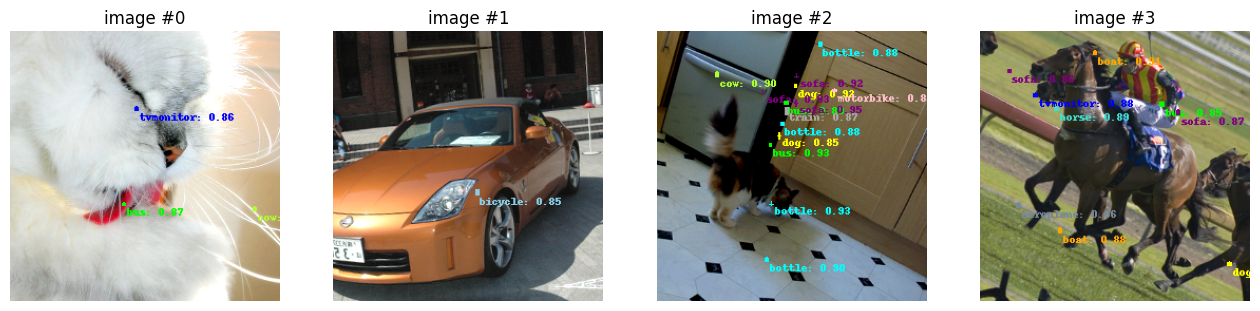

In [35]:
import torch


def draw_predictions(imgs_batch, prediction, labels_codec, threshold=0.01):  
    boxes = [[] for i in range(len(imgs_batch))]
    labels = [[] for i in range(len(imgs_batch))]
    scores = [[] for i in range(len(imgs_batch))]

    for fmap, map_pred in prediction.items():
        pred_classes = map_pred['classes']
        pred_center = map_pred['centerness']
        pred_boxes = map_pred['boxes']

        for img_idx in range(len(pred_classes)):
            img_classes = pred_classes[img_idx]
            img_centerness = pred_center[img_idx]
            img_boxes = pred_boxes[img_idx]
            
            final_scores = img_classes * img_centerness
            max_scores, max_indices = torch.max(final_scores, axis=1)
            mask = max_scores > threshold

            filtered_scores = max_scores[mask]
            filtered_labels = max_indices[mask]
            filtered_boxes = img_boxes[mask]
            
            for score, label, box in zip(filtered_scores, filtered_labels, filtered_boxes):
                scores[img_idx].append(score)
                labels[img_idx].append(label)
                boxes[img_idx].append(box)

    boxes = [
        torch.stack(img_boxes) if len(img_boxes) else torch.zeros((0, 4), dtype=torch.float)
        for img_boxes in boxes
    ]
    scores = [
        torch.stack(img_scores) if len(img_scores) else torch.zeros((0, 1), dtype=torch.float)
        for img_scores in scores
    ]  
    labels = [
        torch.stack(img_labels) if len(img_labels) else torch.zeros((0, 1), dtype=torch.float)
        for img_labels in labels
    ]

    visualize_batch(
        imgs_batch,
        boxes_batch=boxes,
        labels_batch=labels,
        scores_batch=scores,
        codec=labels_codec
    )
            


draw_predictions(img, pred, LabelsCodec(), 0.85)

## Loss function

In [52]:
from fcos import FcosDetectionsCodec


def total_loss(pred, target):
    # targets
    target_classes, target_centerness, target_boxes = target
    all_fmaps = list(target_classes.keys())
    
    first_map = all_fmaps[0]

    b, c, h, w = target_classes[first_map].shape
    target_classes = torch.cat(
        [
            torch.permute(torch.reshape(v, [b, c, -1]), [0, 2, 1]) for k, v in target_classes.items()
        ],
        axis=1
    )

    b, c, h, w = target_centerness[first_map].shape
    target_centerness = torch.cat(
        [
            torch.permute(torch.reshape(v, [b, c, -1]), [0, 2, 1]) for k, v in target_centerness.items()
        ],
        axis=1
    )

    b, c, h, w = target_boxes[first_map].shape
    target_boxes = torch.cat(
        [
            torch.permute(torch.reshape(v, [b, c, -1]), [0, 2, 1]) for k, v in target_boxes.items()
        ],
        axis=1
    )

    # prediction
    pred_classes = torch.cat(
        [
            pred[map_name]['classes'] for map_name in all_fmaps
        ],
        axis=1
    )

    pred_centerness = torch.cat(
        [
            pred[map_name]['centerness'] for map_name in all_fmaps
        ],
        axis=1
    )

    pred_boxes = torch.cat(
        [
            pred[map_name]['boxes'] for map_name in all_fmaps
        ],
        axis=1
    )

    # loss
    print(f"Classes (pred / target): {pred_classes.shape} {target_classes.shape}")
    print(f"Centerness (pred / target): {pred_centerness.shape} {target_centerness.shape}")
    print(f"Boxes (pred / target): {pred_boxes.shape} {target_boxes.shape}")

    
    

img_res = (256, 256)
labels_codec = LabelsCodec()
codec = FcosDetectionsCodec(img_res, labels_codec)

targets = codec.encode(boxes, labels)
res = total_loss(pred, targets)
print("Loss", res)

Classes (pred / target): torch.Size([4, 1364, 20]) torch.Size([4, 1364, 20])
Centerness (pred / target): torch.Size([4, 1364, 1]) torch.Size([4, 1364, 1])
Boxes (pred / target): torch.Size([4, 1364, 4]) torch.Size([4, 1364, 4])
Loss None


In [50]:
pred['P3']['classes'].shape

torch.Size([4, 1024, 20])

### Classification (Focal)

### Regression (IoU)

### Centerness (BCE)